# CS-485: Hands-on 2
 26/02/2025

# Gradient Descent



## Convex vs. Concave Functions

In mathematical optimization, **convex** and **concave** functions play a major role in determining whether we can find global optima efficiently.

- A function $f(x)$ (where $x$ can be a scalar or a vector) is **convex** if and only if for all $x_1, x_2$ in its domain and for all $\lambda$ in the interval $[0, 1]$,
  $$
  f(\lambda x_1 + (1 - \lambda)x_2) \le \lambda f(x_1) + (1 - \lambda) f(x_2).
  $$
  Intuitively, this means the line segment between any two points on the graph of $f$ lies above (or on) the graph.

- A function is **concave** if $-f(x)$ is convex. Equivalently, flipping a convex function vertically yields a concave function.

### Why Convexity Matters
- **Global vs. Local Optimum**: For convex functions, any local minimum is a global minimum. This makes optimization problems on convex functions often much easier to solve.
- Many classic machine learning and data science algorithms (e.g., linear regression with a mean squared error loss) hinge on convex cost functions, making them more tractable to optimize.


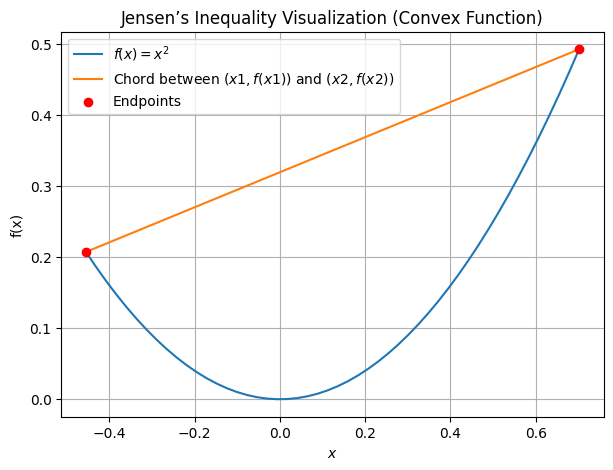

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def f(x):
    """A simple convex function: f(x) = x^2."""
    return x**2

def show_jensen_segment(f, x1, x2, num_points=50):
    """
    Plots the function f(x) between x1 and x2,
    along with the chord connecting (x1, f(x1)) and (x2, f(x2)).
    """
    # Sort x1, x2 for nicer plotting (so we move left to right)
    if x1 > x2:
        x1, x2 = x2, x1

    # Generate a set of points (linspace) between x1 and x2
    X = np.linspace(x1, x2, num_points)
    # Evaluate the function at these points
    fX = f(X)

    # Parametric t in [0,1] for chord
    t_vals = np.linspace(0, 1, num_points)
    # The chord is lambda * f(x1) + (1-lambda) * f(x2),
    # but we also need to represent x along that chord.
    # We'll just re-use X for the horizontal axis and map t to that range
    chord = t_vals * f(x2) + (1 - t_vals) * f(x1)

    # Plot the function
    plt.figure(figsize=(7,5))
    plt.plot(X, fX, label=r'$f(x) = x^2$')

    # Plot the chord
    # We already have X from x1 to x2, which corresponds to t in [0,1].
    # chord[t] corresponds to linear interpolation of f(x1) and f(x2).
    plt.plot(X, chord, label=r'Chord between $(x1, f(x1))$ and $(x2, f(x2))$')

    # Highlight the points (x1, f(x1)) and (x2, f(x2))
    plt.scatter([x1, x2], [f(x1), f(x2)], color='red', zorder=5,
                label='Endpoints')

    # Add some annotations
    plt.title("Jensen’s Inequality Visualization (Convex Function)")
    plt.xlabel(r'$x$')
    plt.ylabel(r'f(x)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
x1_rand = np.random.uniform(-2, 0)
x2_rand = np.random.uniform(0, 2)
show_jensen_segment(f, x1_rand, x2_rand)

## Appendix: What Are Contour Plots?

**Contour plots** provide a way to represent a three-dimensional surface $ z = f(x,y) $ on a two-dimensional plane. Each line (or curve) on a contour plot corresponds to points $(x, y)$ where $ f(x,y) $ is constant. In other words, if you walk **along** a single contour line, the function’s value doesn’t change.

- If the function value (i.e., $z\$) is very low at the center and gradually increases away from that center, we’ll see concentric rings expanding outward (like topographical maps).
- If a contour plot is tightly spaced, it indicates a steeper slope. Widely spaced contours indicate a gentler slope.

Below is a **visual demonstration** using $ f(x, y) = x^2 + y^2 $, which forms a classic "bowl"-shaped surface in 3D. We’ll generate a 2D contour plot for this function over $[-3,3]\times [-3,3]$.


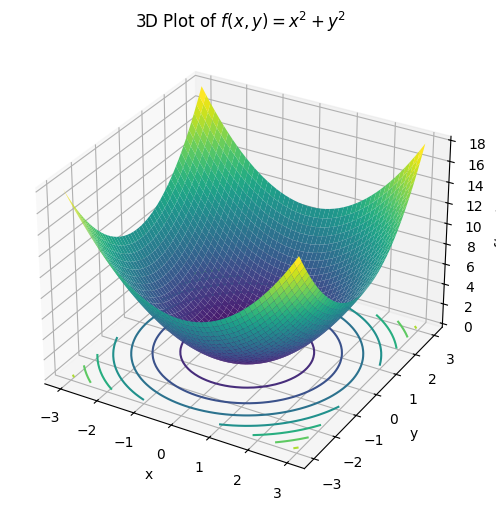

In [4]:
def f(x, y):
    """ A simple function for demonstration: z = x^2 + y^2. """
    return x**2 + y**2

# Create a grid of x, y values
x_vals = np.linspace(-3, 3, 50)
y_vals = np.linspace(-3, 3, 50)
X, Y = np.meshgrid(x_vals, y_vals)

# Compute the function value on the grid
Z = f(X, Y)

# Create a 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

# Optional: You can add a contour projection on the 'floor' (z=0) by using plot_contour
ax.contour(X, Y, Z, zdir='z', offset=Z.min(), cmap='viridis')

ax.set_title(r'3D Plot of $f(x, y) = x^2 + y^2$')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
plt.show()

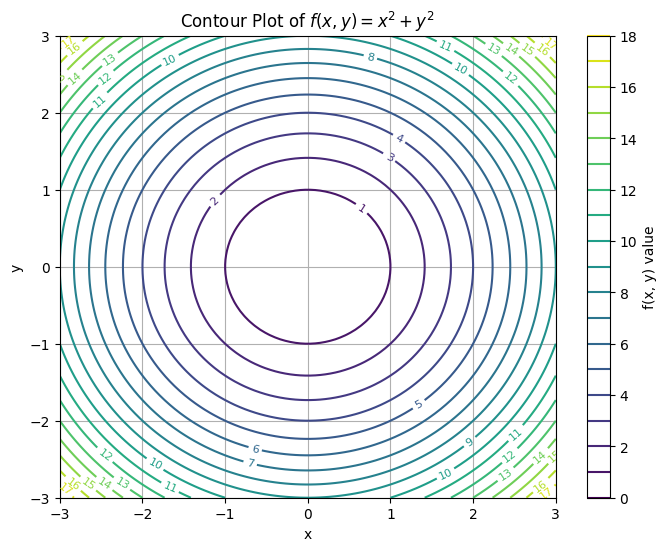

In [5]:
# Create a grid of x, y values
x_vals = np.linspace(-3, 3, 100)
y_vals = np.linspace(-3, 3, 100)
X, Y = np.meshgrid(x_vals, y_vals)

# Compute the function value on the grid
Z = f(X, Y)

# Create the contour plot
plt.figure(figsize=(8, 6))
contours = plt.contour(X, Y, Z, levels=20, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)  # Label some contour lines

# Add a color bar for reference
plt.colorbar(contours, label="f(x, y) value")

plt.title(r'Contour Plot of $f(x, y) = x^2 + y^2$')
plt.xlabel("x")
plt.ylabel("y")
plt.grid(True)
plt.show()

## 2. Understanding Gradients, Derivatives, and Partial Derivatives

### **What is a Derivative?**
A **derivative** measures how a function changes as its input changes.  
It represents the **instantaneous rate of change** of a function.

### **Derivative Definition**
For a function $ f(x) $, the **derivative** at a point $ x $ is:

$$
f'(x) = \lim_{{h \to 0}} \frac{f(x + h) - f(x)}{h}
$$

**Interpreted as:** "How much does $ f(x) $ change when $ x $ changes slightly?"

### **Example: Derivative of a Function**
Given $ f(x) = x^2 $, the derivative is:

$$
f'(x) = 2x
$$

**Meaning:** At $ x = 3 $, the slope is **6** (i.e., increasing $ x $ slightly will increase $ f(x) $ by **approximately 6 times** that change).

---

## **2. What is a Partial Derivative?**
When a function depends on **multiple variables**, a **partial derivative** tells us **how the function changes with respect to one variable while keeping others constant**.

### **Partial Derivative Definition**
For a function $ f(x, y) $, the **partial derivatives** are:

$$
\frac{\partial f}{\partial x} = \lim_{{h \to 0}} \frac{f(x + h, y) - f(x, y)}{h}
$$

$$
\frac{\partial f}{\partial y} = \lim_{{h \to 0}} \frac{f(x, y + h) - f(x, y)}{h}
$$

**Interpreted as:**  
- **$ \frac{\partial f}{\partial x} $**: How $ f(x, y) $ changes as $ x $ changes, keeping $ y $ constant.  
- **$ \frac{\partial f}{\partial y} $**: How $ f(x, y) $ changes as $ y $ changes, keeping $ x $ constant.

### **Example: Partial Derivative of a Function**
Given:

$$
f(x, y) = x^2 + 3xy + y^2
$$

- **Partial derivative w.r.t. $ x $**:
  $$
  \frac{\partial f}{\partial x} = 2x + 3y
  $$
- **Partial derivative w.r.t. $ y $**:
  $$
  \frac{\partial f}{\partial y} = 3x + 2y
  $$

**Meaning:**  
- If $ x $ increases while keeping $ y $ constant, the function increases at a rate of **$ 2x + 3y $**.  
- If $ y $ increases while keeping $ x $ constant, the function increases at a rate of **$ 3x + 2y $**.

---

## **3. What is a Gradient?**
A **gradient** is a vector that contains all the **partial derivatives** of a function.  
It **points in the direction of the steepest increase** of the function.

### **Gradient Definition**
For a function $ f(x, y) $, the **gradient** is:

$$
\nabla f = \left( \frac{\partial f}{\partial x}, \frac{\partial f}{\partial y} \right)
$$

**Interpreted as:**  
- The gradient tells us **which direction** increases $ f(x, y) $ the most.  
- Used in **gradient descent** to minimize a function.

### **Example: Gradient of a Function**
For $ f(x, y) = x^2 + 3xy + y^2 $, we already found:

$$
\frac{\partial f}{\partial x} = 2x + 3y, \quad \frac{\partial f}{\partial y} = 3x + 2y
$$

Thus, the **gradient** is:

$$
\nabla f = (2x + 3y, 3x + 2y)
$$

**Meaning:**  
- At $ (x, y) = (1,2) $, the gradient is **(8, 7)**.  
- The function increases **fastest** in the direction **(8,7)**.  
- To **decrease** the function, move in the **opposite direction** (negative gradient).

---


## 3. Minima, Maxima, and Saddle Points

When analyzing a function $f(x)$, we are often interested in specific points where its behavior changes:

1. **Local Minimum**: A point $x^*$ is a local minimum if $f(x^*) \le f(x)$ for all $x$ in some neighborhood around $x^*$.  
2. **Local Maximum**: A point $x^*$ is a local maximum if $f(x^*) \ge f(x)$ for all $x$ in some neighborhood around $x^*$.  
3. **Saddle Point**: A point that is neither a strict local max nor a local min, but the gradient can be zero (stationary). The function "curves up" in one direction and "curves down" in another.

In terms of derivatives (or gradients, if $x$ is multidimensional):
- A critical or stationary point occurs where the gradient of $f$ is zero:
  $$
  \nabla f(x) = 0.
  $$

However, identifying whether this point is a minimum, maximum, or saddle point usually requires further analysis (like examining the Hessian matrix in higher dimensions).

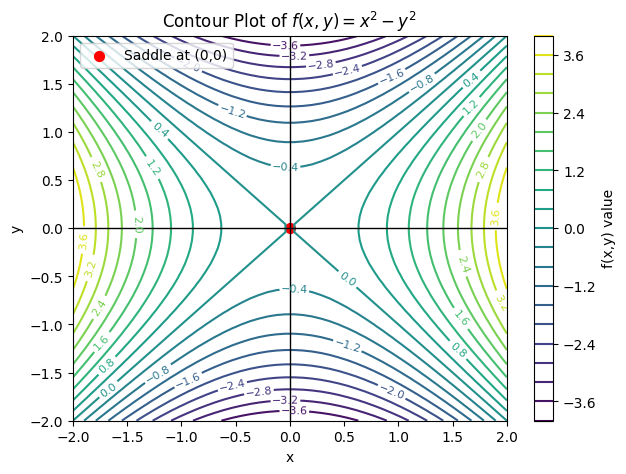

In [6]:
def saddle_function(x, y):
    """Saddle function: z = x^2 - y^2."""
    return x**2 - y**2

# Generate a mesh grid
x_vals = np.linspace(-2, 2, 50)
y_vals = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(x_vals, y_vals)
Z = saddle_function(X, Y)

# --- 2D Contour Plot ---
plt.figure(figsize=(7, 5))
contours = plt.contour(X, Y, Z, levels=20, cmap='viridis')
plt.clabel(contours, inline=True, fontsize=8)
plt.xlabel("x")
plt.ylabel("y")
plt.title(r'Contour Plot of $f(x, y) = x^2 - y^2$')
plt.axhline(0, color='black', lw=1)
plt.axvline(0, color='black', lw=1)
plt.colorbar(label="f(x,y) value")

# Mark the critical point (0,0)
plt.scatter(0, 0, color='red', s=50, label='Saddle at (0,0)')
plt.legend()
plt.show()

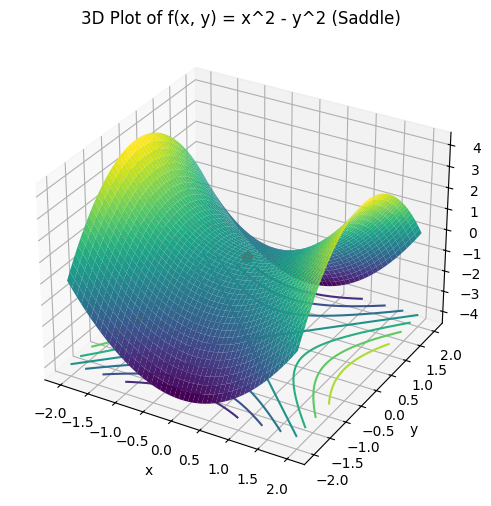

In [7]:
# --- 3D Surface Plot ---
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
ax.set_title("3D Plot of f(x, y) = x^2 - y^2 (Saddle)")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.contour(X, Y, Z, zdir='z', offset=Z.min(), cmap='viridis')

# Mark the saddle point in 3D (optional)
ax.scatter(0, 0, saddle_function(0,0), color='red', s=50)

plt.show()

### Gradient Descent and Critical Points

Gradient Descent is an iterative algorithm for finding a point where the **gradient** (derivative) of a function is zero, ideally a **minimum**. However, if the function is **not** convex (or even non-concave in some directions), that zero-gradient point could be:

- A **global minimum** (best-case scenario for convex functions).
- A **local minimum** (if the function has multiple "valleys").
- A **local maximum**.
- A **saddle point**, like the example above.

#### Gradient Descent Recap

For a function $ f(\mathbf{x}) $ with parameters $\mathbf{x}$, Gradient Descent updates $\mathbf{x}$ at each step using:
$$
\mathbf{x}_{\text{new}} \;=\; \mathbf{x}_{\text{old}} \;-\;\tau \,\nabla f(\mathbf{x}_{\text{old}}),
$$
where $\tau$ is the **step size**(or learning rate), and $\nabla f$ is the gradient.

#### Convergence in Gradient Descent

**Convergence** in optimization refers to the idea that an iterative method (like Gradient Descent) **stabilizes** around a point where the parameters no longer change significantly. In other words, the sequence of updates for the parameter vector $ \mathbf{x}^{(k)} $ approaches some limit $\mathbf{x}^*$ as $k \to \infty$.

Let $ \mathbf{x}^{(k)} $ denote the parameter vector at the $k$-th iteration of Gradient Descent. We say that **Gradient Descent converges** if, as $k$ grows large, the updates yield:

$$
\lim_{k \to \infty} \mathbf{x}^{(k)} = \mathbf{x}^*.
$$

where $\mathbf{x}^*$ is a point that satisfies

$$
\nabla f(\mathbf{x}^*) = \mathbf{0}.
$$

In many **convex** optimization settings, $\mathbf{x}^*$ is the **global minimum**. However, in **non-convex** settings, $\mathbf{x}^*$ could be a local minimum, a local maximum, or a saddle point.

In [8]:
def gradient_descent(f, df, x_init, step_size=0.1, num_iterations=100):

    ##################
    # YOUR CODE HERE #
    ##################

    return None

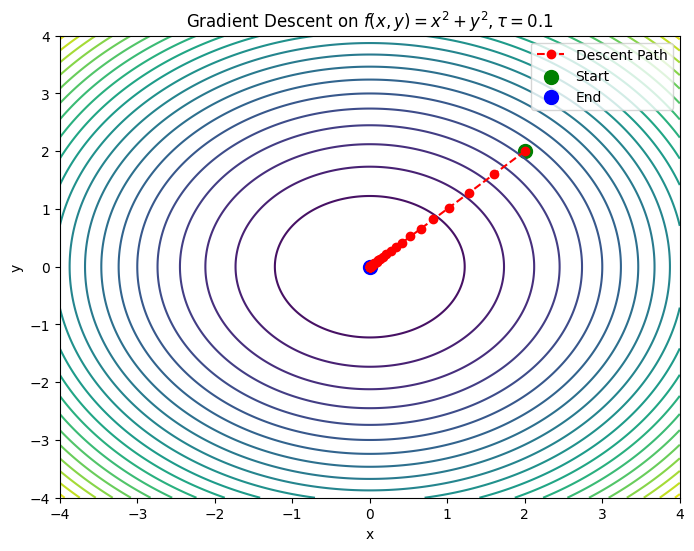

In [ ]:
def f(x,y):
   return x**2 + y**2

def df(point):
   return np.array([2*point[0], 2*point[1]])

history1 = gradient_descent(f, df, x_init=np.array([2,2]), step_size=0.1,
                           num_iterations=50)

history2 = gradient_descent(f, df, x_init=np.array([2,2]), step_size=0.99,
                           num_iterations=5)

history3 = gradient_descent(f, df, x_init=np.array([2,2]), step_size=0.001,
                           num_iterations=100)

# Create a mesh grid for plotting
x_vals = np.linspace(-4, 4, 400)
y_vals = np.linspace(-4, 4, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = f(X, Y)

plt.figure(figsize=(8, 6))
# Draw contour lines
plt.contour(X, Y, Z, levels=30, cmap="viridis")

# Plot the descent path
history = np.array(history1)
plt.plot(history[:,0], history[:,1], 'o--', color="red", label="Descent Path")

# Annotate the starting point
plt.scatter(history[0,0], history[0,1], color="green", s=100, label="Start")
# Annotate the final point
plt.scatter(history[-1,0], history[-1,1], color="blue", s=100, label="End")

plt.title(r'Gradient Descent on $f(x, y) = x^2 + y^2, \tau = 0.1$')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

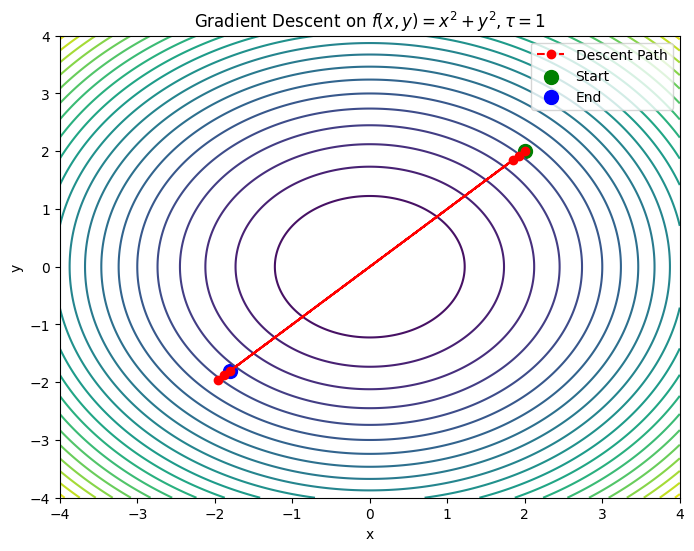

In [ ]:
plt.figure(figsize=(8, 6))
# Draw contour lines
plt.contour(X, Y, Z, levels=30, cmap="viridis")

# Plot the descent path
history = np.array(history2)
plt.plot(history[:,0], history[:,1], 'o--', color="red", label="Descent Path")

# Annotate the starting point
plt.scatter(history[0,0], history[0,1], color="green", s=100, label="Start")
# Annotate the final point
plt.scatter(history[-1,0], history[-1,1], color="blue", s=100, label="End")

plt.title(r'Gradient Descent on $f(x, y) = x^2 + y^2, \tau = 1$')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

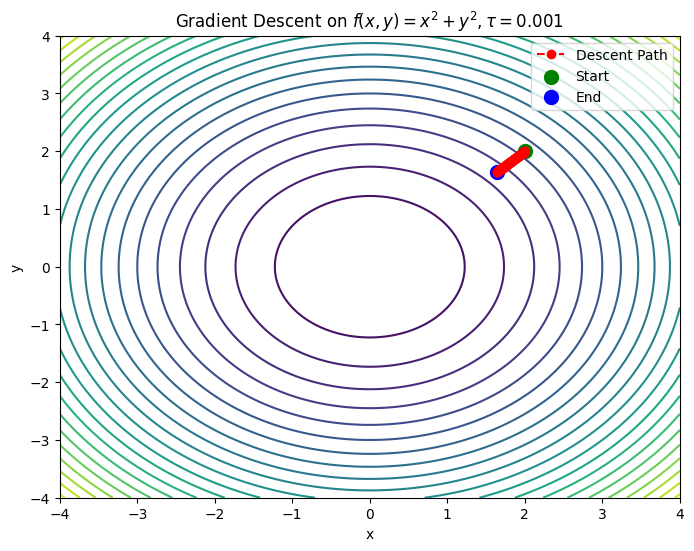

In [ ]:
plt.figure(figsize=(8, 6))
# Draw contour lines
plt.contour(X, Y, Z, levels=30, cmap="viridis")

# Plot the descent path
history = np.array(history3)
plt.plot(history[:,0], history[:,1], 'o--', color="red", label="Descent Path")

# Annotate the starting point
plt.scatter(history[0,0], history[0,1], color="green", s=100, label="Start")
# Annotate the final point
plt.scatter(history[-1,0], history[-1,1], color="blue", s=100, label="End")

plt.title(r'Gradient Descent on $f(x, y) = x^2 + y^2, \tau = 0.001$')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

### When Does Gradient Descent Converge?

1. **Appropriate Learning Rate ($ \tau $)**  
   - If $ \tau $ is **too large**, updates might overshoot the minimum and even diverge.  
   - If $ \tau $ is **too small**, convergence is slow (though, in theory, it may still converge).

2. **Smoothness & Lipschitz Continuity**  
   - In theoretical analysis, if the gradient $ \nabla f(\mathbf{x}) $ is [Lipschitz continuous](https://en.wikipedia.org/wiki/Lipschitz_continuity) (i.e., not changing too abruptly), Gradient Descent with an appropriately chosen constant step size is guaranteed to converge at least to a **critical point**.

3. **Convexity Assumptions**  
   - For **strictly convex** $f(\mathbf{x})$, any critical point is the unique global minimum, so convergence to $ \nabla f(\mathbf{x}^*) = \mathbf{0} $ implies finding the best possible solution.



### Issues with gradient descent

Sometimes, Gradient Descent **does not** smoothly follow the steepest path “downhill” into a valley. Instead, it makes long sweeps back and forth (a *zig-zag*) before converging. This is particularly common when:

- **Features (or dimensions) are on very different scales.**  
   - One direction in the parameter space is “steep,” while another is “flat.”  
   - Updates in the steep dimension overshoot, then the algorithm compensates back in the flat dimension, resulting in oscillatory behavior.
   Consider the function:

### Visual Example
$$
f(x, y) = 4x^2 - 4xy + y^2.
$$

- **Contour Shapes**: The level sets are *very elliptical*, stretched out along the $y$-axis (which corresponds to a smaller scale in $y$ and a larger scale in $x$).  
- When you apply standard Gradient Descent, each step along $x$ might overshoot and cause a big update in $y$, then the next step tries to correct $y$, producing a *zig-zag* pattern.

### Consequences of Zig-Zagging

1. **Slow Convergence**  
   - Rather than smoothly rolling to the bottom of the “valley,” the algorithm expends many steps oscillating around the center.

2. **Potential Instability**  
   - If the *learning rate* is set too large, this zig-zagging can become more extreme, sometimes leading to divergence if updates overshoot repeatedly.

IndexError: too many indices for array: array is 0-dimensional, but 2 were indexed

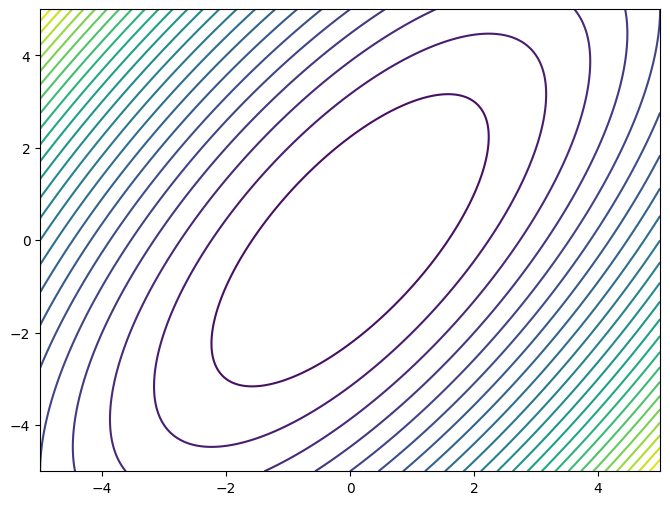

In [9]:
def f(x, y):
    return 4*x**2 - 4*x*y + 2*y**2

def grad_f(point):

  ##################
  # YOUR CODE HERE #
  ##################

    return None

# Hyperparameters
learning_rate = 0.2

history = gradient_descent(f, grad_f, x_init=np.array([2,2]),
                           step_size=learning_rate, num_iterations=10)

# Create a mesh grid for plotting
x_vals = np.linspace(-5, 5, 400)
y_vals = np.linspace(-5, 5, 400)
X, Y = np.meshgrid(x_vals, y_vals)
Z = f(X, Y)

plt.figure(figsize=(8, 6))
# Draw contour lines
plt.contour(X, Y, Z, levels=30, cmap="viridis")

# Plot the descent path
history = np.array(history)
plt.plot(history[:,0], history[:,1], 'o--', color="red", label="Descent Path")

# Annotate the starting point
plt.scatter(history[0,0], history[0,1], color="green", s=100, label="Start")
# Annotate the final point
plt.scatter(history[-1,0], history[-1,1], color="blue", s=100, label="End")

plt.title(r'Gradient Descent on $f(x, y) = x^2 + y^2$')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

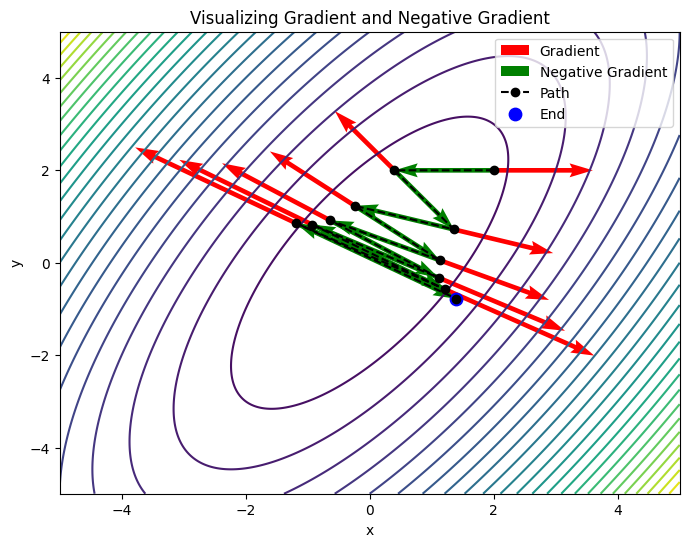

In [ ]:
plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z, levels=30, cmap="viridis")

for i in range(len(history) - 1):
    x_current, y_current = history[i]
    grad = grad_f(history[i])

    # Plot gradient vector in red
    plt.quiver(
        x_current, y_current,      # base point
        grad[0], grad[1],          # direction
        color='red', angles='xy', scale_units='xy', scale=5,
        label="Gradient" if i == 0 else ""
    )
    # Plot negative gradient vector in green
    plt.quiver(
        x_current, y_current,
        -grad[0], -grad[1],
        color='green', angles='xy', scale_units='xy', scale=5,
        label="Negative Gradient" if i == 0 else ""
    )

plt.plot(history[:,0], history[:,1], 'o--', color="black", label="Path")
plt.scatter(history[-1,0], history[-1,1], color="blue", s=80, label="End")
plt.title("Visualizing Gradient and Negative Gradient")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

## Mitigations

1. **Feature Scaling / Normalization**  
   - By **standardizing** features to comparable ranges (e.g., $[0,1]$ or zero-mean/unit-variance), you make the contours more “circular,” reducing the zig-zag.  
   - In practice, scaling input features (and sometimes target features) is a *best practice* before Gradient Descent.

2. **Adaptive Learning Rates**  
   - **Momentum**: A method that accumulates velocity, smoothing out updates so they don’t purely rely on the instantaneous gradient.  
   - **RMSProp, Adam**: Adjust the learning rate per-parameter based on the historical magnitude of gradients. If one dimension is very steep, these methods effectively reduce the step size in that dimension.

3. **Smaller Learning Rate**  
   - While this can help reduce the severity of zig-zag, it also makes convergence slower in general. A better solution is often feature scaling or momentum-based optimizers.

## Momentum Gradient Descent

Standard Gradient Descent updates parameters $ \theta $ at each step by subtracting a scaled version of the current gradient:

$$
x_{t+1} = x_t \;-\; \tau \,\nabla f(x_t),
$$

where $ \tau $ is the learning rate. However, this can lead to **zig-zagging** and slow convergence in certain landscapes.

## 1. Intuition

**Momentum** methods aim to smooth out these updates by accumulating a velocity term, akin to a ball rolling down a slope. Instead of using just the *current* gradient, we blend in *past* gradients to build *inertia* in a particular direction. This helps us:

- **Dampen oscillations** in directions where the gradient sign flips frequently.  
- **Accelerate** the descent in consistent directions.  

## 2. Mathematical Formulation

Let $ \mathbf{v}_t $ be the **velocity** at iteration $ t $. We update it with:

$$
\mathbf{v}_{t+1} \;=\; \beta \,\mathbf{v}_t \;+\; \tau\,\nabla f(x_t),
$$

where $ 0 \le \beta < 1 $ is the **momentum coefficient** (sometimes denoted as $ \gamma $) and $ \tau $ is the learning rate. Then we update the parameters $ \theta $ using:

$$
x_{t+1} \;=\; x_t \;-\; \mathbf{v}_{t+1}.
$$

### Key Points

- $ \beta $ close to 1 means **more momentum**, giving more weight to *historical* gradients.  
- $ \beta $ close to 0 means we fall back to the usual Gradient Descent behavior.  

## 3. Algorithm Steps

1. **Initialize**:
   - $ x_0 $ (parameter vector, often random or zero)
   - $ \mathbf{v}_0 = 0 $ (initial velocity)

2. **For each iteration** $ t = 0, 1, 2, \ldots $:
   1. Compute gradient:
      $$
      \mathbf{g}_t = \nabla f(x_t).
      $$
   2. Update velocity:
      $$
      \mathbf{v}_{t+1} = \beta \ \mathbf{v}_t + \tau \ \mathbf{g}_t.
      $$
   3. Update parameters:
      $$
      x_{t+1} = x_t - \mathbf{v}_{t+1}.
      $$

3. **Repeat** until convergence criteria are met (e.g., gradient norm is small, parameter updates are small, or a maximum number of iterations is reached).

In [12]:
import numpy as np

def momentum_gradient_descent(f, df, x_init, step_size=0.1, momentum=0.9, num_iterations=100):

    ##################
    # YOUR CODE HERE #
    ##################

    return None

In [13]:
history = momentum_gradient_descent(f, df, x_init=np.array([2,2]),
                                    step_size=0.2, momentum=0.7,
                                    num_iterations=10)

plt.figure(figsize=(8, 6))
# Draw contour lines
plt.contour(X, Y, Z, levels=30, cmap="viridis")

# Plot the descent path
history = np.array(history)
plt.plot(history[:,0], history[:,1], 'o--', color="red", label="Descent Path")

# Annotate the starting point
plt.scatter(history[0,0], history[0,1], color="green", s=100, label="Start")
# Annotate the final point
plt.scatter(history[-1,0], history[-1,1], color="blue", s=100, label="End")

plt.title(r'Gradient Descent on $f(x, y) = x^2 + y^2$')
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

NameError: name 'df' is not defined

## Momentum: Escaping Local Optima (With No Guarantees)

While **Momentum Gradient Descent** is often praised for faster convergence and reduced oscillations, it’s important to understand **what it can and cannot guarantee**:

### 1. Momentum Does Not Guarantee Global Convergence

Even with momentum, **non-convex** functions (like deep neural network loss surfaces) may contain multiple local minima, saddle points, or plateaus. **Momentum alone** does **not** guarantee that you’ll find the **global** optimum. It simply **modifies the update step** to incorporate velocity from past gradients.

### 2. How Momentum Helps Overcome Local Optima

1. **Inertial Force**  
   - Because momentum **accumulates** gradient information over time, the parameter updates can have enough “speed” to roll over small hills or escape shallow local minima.  
   - If the local minimum is **not too deep**, the built-up velocity may allow the algorithm to climb out and continue searching.

2. **Escaping Saddle Points**  
   - In higher-dimensional problems, **saddle points** (where some directions are uphill and others downhill) can trap plain Gradient Descent if updates become very small.  
   - Momentum can push the parameters through these flat or semi-flat regions more effectively.

### 3. No Formal Convergence Criteria to the Global Minimum

- **Local vs. Global**:  
  - Momentum doesn’t change the underlying function itself, just the dynamics of **how** parameters move. In a highly non-convex landscape, you could still get stuck in a deep local minimum if momentum isn’t sufficient to escape.  
- **Empirical Success**:  
  - Despite the lack of **theoretical guarantees** in non-convex settings, **momentum-based optimizers** (e.g., SGD with Momentum, Adam) perform remarkably well in practice for many complex tasks (like training deep neural networks).

## 4. Practical Guidelines

- **Combine Momentum With Other Techniques**  
  - Techniques like **learning rate scheduling**, **batch normalization**, and **proper weight initialization** further reduce the chance of getting stuck.
- **Hyperparameter Tuning**  
  - A well-chosen **momentum coefficient** can help find a balance between stable updates and enough “push” to jump out of shallow minima.  
  - The **learning rate** ($\alpha$) also needs to be tuned: too large can lead to divergence, too small might prevent escaping local traps.


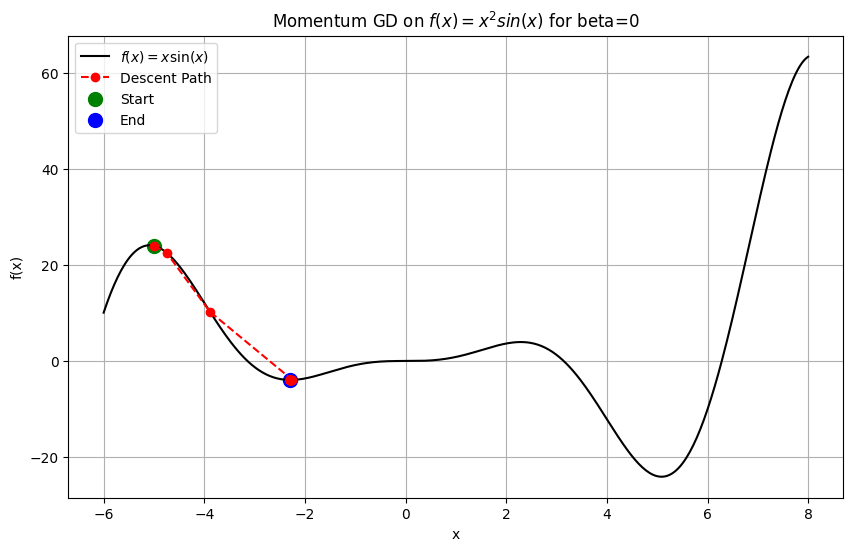

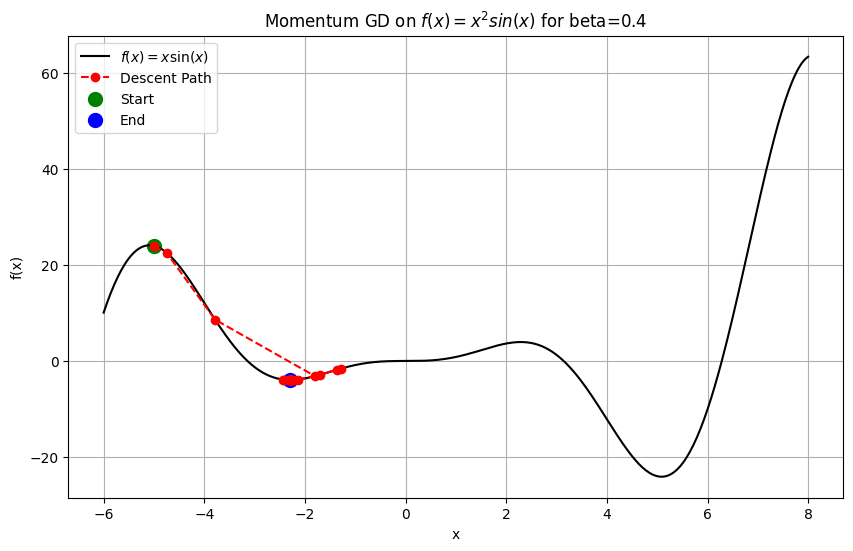

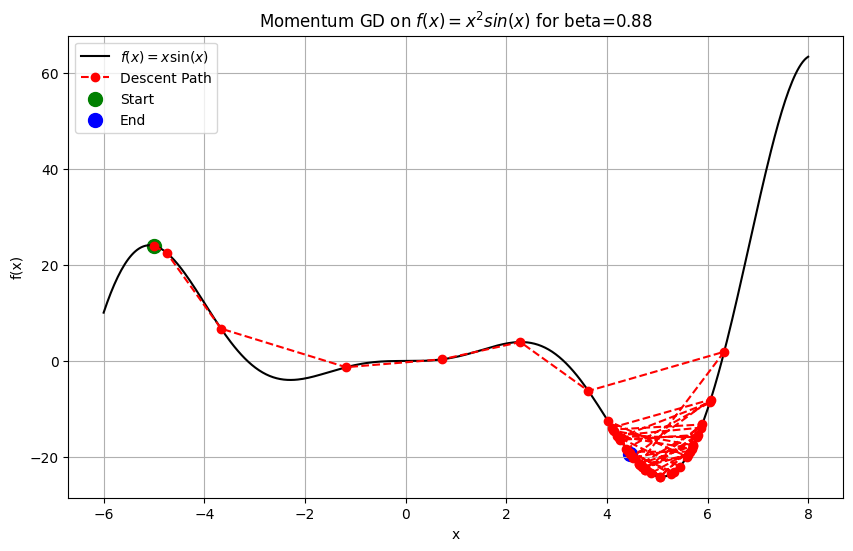

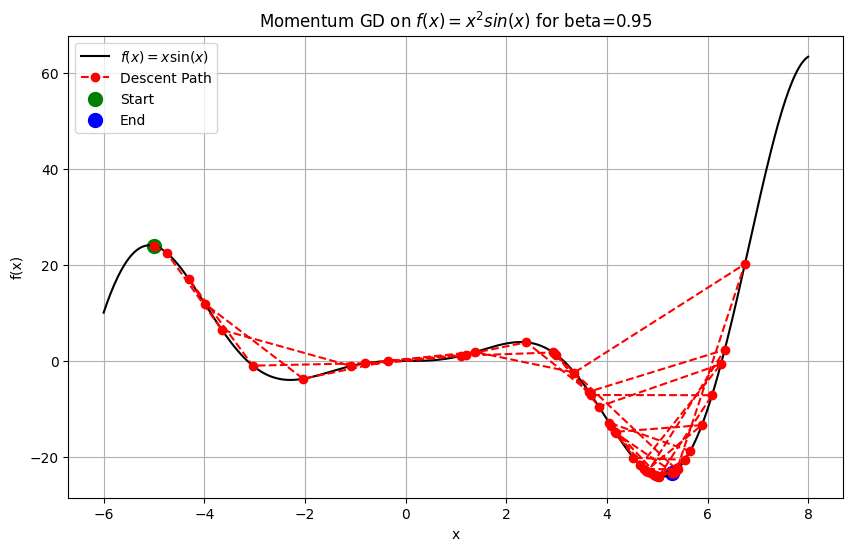

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# 1) Define the function and its derivative
def f(x):
    return x**2 * np.sin(x)

def f_prime(x):
    """Derivative of x sin(x) = sin(x) + x cos(x)."""
    return 2*x * np.sin(x) + x**2 * np.cos(x)

# 2) Momentum Gradient Descent implementation (1D)
def momentum_gd(f, f_grad, x_init, alpha=0.1, beta=0.9, n_iter=50):
    """
    f       : function to minimize
    f_grad  : derivative of f
    x_init  : initial guess for x
    alpha   : learning rate
    beta    : momentum coefficient
    n_iter  : number of iterations
    Returns arrays of (x_values, f_values) over iterations.
    """
    x = x_init
    v = 0  # velocity
    x_history = [x]
    f_history = [f(x)]

    for i in range(n_iter):
        grad = f_grad(x)
        # Update velocity
        v = beta * v + alpha * grad
        # Update x (gradient descent subtracts the velocity)
        x = x - v

        x_history.append(x)
        f_history.append(f(x))

    return np.array(x_history), np.array(f_history)

# 3) Compare two runs: low vs. high momentum
x0 = -5           # starting point
alpha = 0.1       # learning rate
n_iter = 50        # number of iterations

# No momentum
x_hist_no_momentum, f_hist_no_momentum = momentum_gd(f, f_prime, x0, alpha, 0, n_iter)

# Low momentum
beta_low = 0.4
x_hist_low, f_hist_low = momentum_gd(f, f_prime, x0, alpha, beta_low, n_iter)

# Right momentum
beta_right = 0.88
x_hist_rign, f_hist_right = momentum_gd(f, f_prime, x0, alpha, beta_right, n_iter)

# High momentum
beta_high = 0.95
x_hist_high, f_hist_high = momentum_gd(f, f_prime, x0, alpha, beta_high, n_iter)

def plot_func(history, beta):
    x_plot = np.linspace(-6, 8, 400)
    y_plot = f(x_plot)
    plt.figure(figsize=(10, 6))
    plt.plot(x_plot, y_plot, label=r"$f(x) = x \sin(x)$", color="black")
    plt.plot(history[:,0], history[:,1], 'o--', color="red", label="Descent Path")
    plt.scatter(history[0,0], history[0,1], color="green", s=100, label="Start")
    plt.scatter(history[-1,0], history[-1,1], color="blue", s=100, label="End")
    plt.title(r'Momentum GD on $f(x) = x^2 sin(x)$ for beta={}'.format(beta))
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_func(np.array([x_hist_no_momentum, f_hist_no_momentum]).T, 0)
plot_func(np.array([x_hist_low, f_hist_low]).T, beta_low)
plot_func(np.array([x_hist_rign, f_hist_right]).T, beta_right)
plot_func(np.array([x_hist_high, f_hist_high]).T, beta_high)

# Exercise: Linear Regression
## Mathematical Formulation

We have a dataset of $N$ observations, each observation consisting of:

- **Feature(s)**: $x_i$  
- **Target/Label**: $y_i$

For simplicity, consider **one-dimensional** features (you can easily extend to multiple dimensions). We want to find parameters $w$ (slope) and $b$ (intercept) such that our **predicted value** is:

$$
\hat{y}_i = w x_i + b.
$$

## 1. Objective: Mean Squared Error (MSE)

We measure the **error** between the predicted value $\hat{y}_i$ and the actual value $y_i$. The most common metric in **Ordinary Least Squares** is the **Mean Squared Error (MSE)**:

$$
\text{MSE}(w, b) \;=\; \frac{1}{N}\,\sum_{i=1}^{N} \bigl(\hat{y}_i - y_i\bigr)^2
\;=\;\frac{1}{N}\,\sum_{i=1}^{N} \bigl(w x_i + b - y_i\bigr)^2.
$$

The goal is to **minimize** this cost function w.r.t. $w$ and $b$. Formally, we write:

$$
\min_{w,\,b}\;\; \frac{1}{N}\,\sum_{i=1}^{N} \bigl(w x_i + b - y_i\bigr)^2.
$$

## 2. Normal Equations (Analytical Approach)

For **simple linear regression**, you can solve this minimization **analytically** by setting the partial derivatives to zero:

1. Compute
   $$
   \frac{\partial \,\text{MSE}}{\partial w} = 0,
   \quad
   \frac{\partial \,\text{MSE}}{\partial b} = 0,
   $$
2. Solve for $w$ and $b$ to get the **closed-form solution**.

## 3. Gradient Descent (Iterative Approach)

Alternatively, **Gradient Descent** finds a solution by **iteratively** adjusting $w$ and $b$ based on the *direction* of the gradient:

$$
w \;:=\; w \;-\; \alpha \,\frac{\partial \,\text{MSE}}{\partial w},
\qquad
b \;:=\; b \;-\; \alpha \,\frac{\partial \,\text{MSE}}{\partial b},
$$

where $\alpha$ is the **learning rate** and the partial derivatives are:

$$
\frac{\partial \,\text{MSE}}{\partial w}
= \frac{2}{N}\,\sum_{i=1}^{N}\bigl(w x_i + b - y_i\bigr)\,x_i,
\quad
\frac{\partial \,\text{MSE}}{\partial b}
= \frac{2}{N}\,\sum_{i=1}^{N}\bigl(w x_i + b - y_i\bigr).
$$

Starting from an initial guess $(w_0, b_0)$, the updates **iteratively reduce** the MSE until convergence or a stopping criterion is met (e.g., small gradient, small improvement in error, or a maximum number of iterations).

**Advantages** of Gradient Descent:
- **Scalability**: In higher dimensions (many features), it can be more efficient than solving large matrix inversions.
- **Extensibility**: Works for various cost functions (e.g., if you change from squared error to absolute error or add regularization terms).

We are going to use data from rented bikes

In [ ]:
import numpy as np

url = 'https://raw.githubusercontent.com/lpoly/public_data/main/car_data.csv'

# Load data from CSV
car_data = np.loadtxt(url, dtype=float, delimiter=',', skiprows=1)
car_data

array([[1.7500e+02, 2.3315e+03, 6.5548e+03, 5.5300e+00],
       [2.0000e+02, 1.9849e+03, 5.0308e+03, 4.2500e+00],
       [8.8000e+01, 1.4832e+03, 1.9665e+03, 8.0800e+00],
       ...,
       [8.8000e+01, 1.0337e+03, 1.5895e+03, 8.5000e+00],
       [1.1000e+02, 1.4610e+03, 4.2934e+03, 8.5000e+00],
       [8.8000e+01, 1.4978e+03, 4.0968e+03, 8.0800e+00]])

In [ ]:
# Extracting columns
data = car_data[:, 0:3]  # Horsepower, Weight, Displacement
target = car_data[:, 3]  # mean consumption

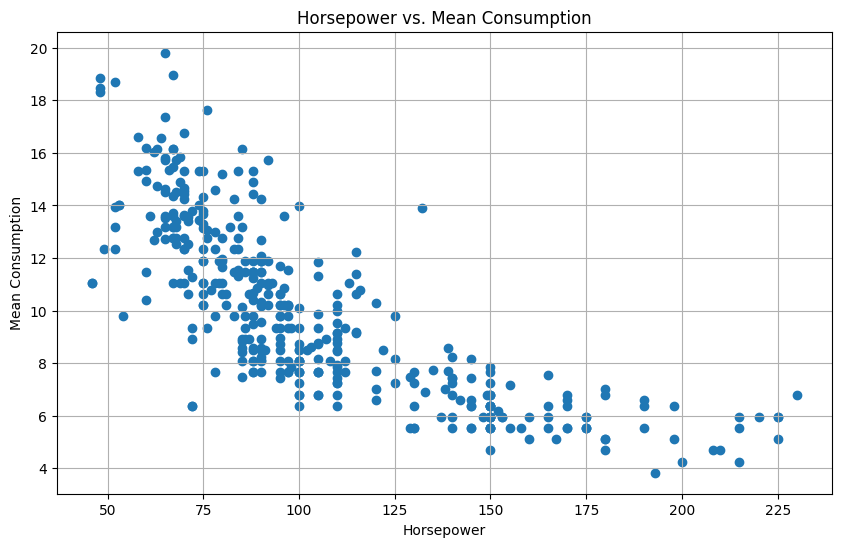

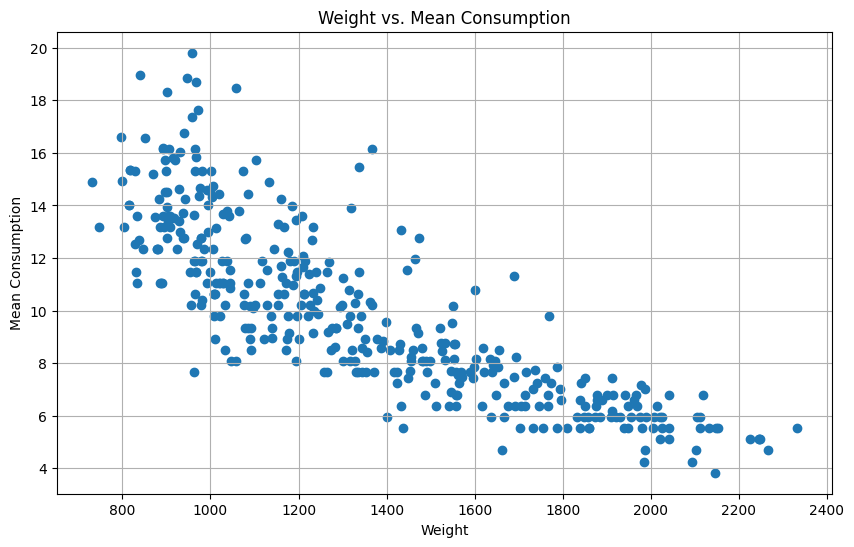

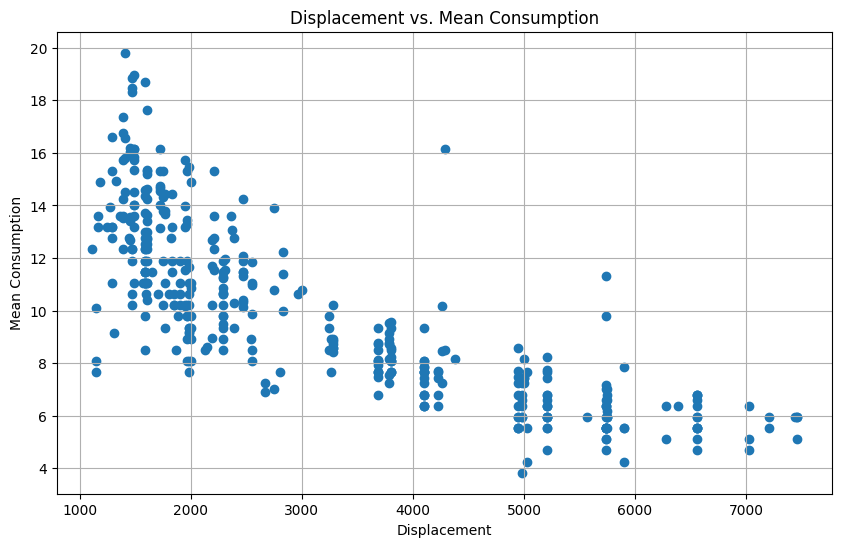

In [ ]:
column_names = ['Horsepower', 'Weight', 'Displacement', 'Mean Consumption(Target)']

for i, feature in enumerate(column_names[:-1]):
    plt.figure(figsize=(10, 6))
    plt.scatter(car_data[:, i], target)
    plt.title(f'{feature} vs. Mean Consumption')
    plt.xlabel(feature)
    plt.ylabel('Mean Consumption')
    plt.grid(True)
    plt.show()

Visually there seems to be a linear relationship between the variables and the target

Let's try fitting a linear regression model for each variable(variable=feature=attribute)

In [15]:
def mse(w, b, X, y):
    predictions = np.dot(X, w) + b
    return np.mean((y - predictions) ** 2)

def gradient(w, b, X, y):
    ##################
    # YOUR CODE HERE #
    ##################
    return dw, db

In [ ]:
# Modify gradient descent function to ensure w and b are floats
def gradient_descent(X, y, f, df, learning_rate=0.1, epochs=50, w_init=0.0, b_init=0.0):

    ##################
    # YOUR CODE HERE #
    ##################

    return None

In [16]:
# Perform gradient descent for each feature separately and together
X_single = data[:, 0].reshape(-1, 1)
history = gradient_descent(X_single, target, mse, gradient, learning_rate=0.1,
                           w_init=-5.0, b_init=50.0)

history

NameError: name 'data' is not defined

## **Standardization in Machine Learning**

### What is Standardization?
Standardization is a feature scaling technique that **transforms data** to have **zero mean** and **unit variance**. It ensures that all features contribute equally to the model, preventing issues caused by different scales.

The formula for standardization is:

$$
X_{\text{standardized}} = \frac{X_{\text{original}} - \mu}{s}
$$

Where:
- $ X_{\text{original}} $ = original feature values
- $ \mu $ = mean of the feature
- $ s $ = standard deviation of the feature

### Why Standardize Data?
1. **Improves Gradient Descent Convergence**: When features have vastly different scales, gradient descent might update some parameters too fast and others too slow.
2. **Avoids Feature Dominance**: Without scaling, a feature with a larger range (e.g., "Weight" in kg vs. "Horsepower") might dominate the learning process.
3. **Enables Fair Comparison**: Machine learning models (e.g., linear regression, neural networks) often assume all features are on a similar scale.

In [17]:
data_mean = np.mean(data, axis=0)
data_std = np.std(data, axis=0)
data_standardized = (data - data_mean) / data_std

data_mean, data_std

NameError: name 'data' is not defined

In [18]:
X_single = data_standardized[:, 0].reshape(-1, 1)
history = gradient_descent(X_single, target, mse, gradient, learning_rate=0.1,
                           w_init=-5.0, b_init=50.0)

history

NameError: name 'data_standardized' is not defined

## **Unstandardization: Converting Back to Original Scale**
After training a model on standardized data, we often need to **convert predictions back** to the **original scale** for interpretation.

If a feature was standardized as:

$$
X_{\text{standardized}} = \frac{X_{\text{original}} - \mu}{s}
$$

Then, the original value can be recovered using:

$$
X_{\text{original}} = X_{\text{standardized}} \cdot s + \mu
$$

Where:
- $ s $ = standard deviation of the original feature
- $ \mu $ = mean of the original feature

---


##  Understanding Standardization in Regression

When we standardize a feature, we transform it using:

$$
X_{\text{standardized}} = \frac{X_{\text{original}} - \mu}{s}
$$

When applying **linear regression** on standardized data, the model equation is:

$$
y = w_{\text{standardized}} \cdot X_{\text{standardized}} + b_{\text{standardized}}
$$

---

## Step 1: Expanding $X_{\text{standardized}}$

Substituting $X_{\text{standardized}} = \frac{X_{\text{original}} - \mu}{s}$ into the equation:

$$
y = w_{\text{standardized}} \cdot \frac{X_{\text{original}} - \mu}{s} + b_{\text{standardized}}
$$

---

## Step 2: Rearranging the Equation

Distribute $w_{\text{standardized}}$:

$$
y = \frac{w_{\text{standardized}}}{s} X_{\text{original}} - \frac{w_{\text{standardized}} \cdot \mu}{s} + b_{\text{standardized}}
$$

Now, we recognize the new coefficients:

- **New weight (for original scale):**  
  $$
  w_{\text{original}} = \frac{w_{\text{standardized}}}{\sigma}
  $$
  This is why we **don’t subtract the mean ($\mu$)** here. The weight is only scaled by $\sigma$.
  
- **New bias (for original scale):**  
  $$
  b_{\text{original}} = b_{\text{standardized}} - \frac{w_{\text{standardized}} \cdot \mu}{s}
  $$
  Here, the mean ($\mu$) **is** involved because it shifts all predictions.

---



In [19]:
# Retrieve the final values from history
final_w, final_b = history[-1]

# Convert parameters back to original scale
w_original = final_w / data_std[0]  # Undo standardization
b_original = final_b - (final_w * data_mean[0] / data_std[0])  # Adjust bias

# Generate predictions using the original scale
X_hp_original = data[:, 0]  # Use the original Horsepower data
y_pred = w_original * X_hp_original + b_original  # Compute predictions

# Plot the original data and the fitted line
plt.figure(figsize=(8, 6))
plt.scatter(X_hp_original, target, label="Original Data")
plt.plot(X_hp_original, y_pred, label="Fitted Line", color="red", linewidth=2)
plt.xlabel("Horsepower")
plt.ylabel("Mean Consumption (km/l)")
plt.title("Linear Regression Fit (Using Original Data)")
plt.legend()
plt.grid(True)
plt.show()

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [20]:
# Perform gradient descent and store history
X_single = data_standardized[:, 0].reshape(-1, 1)
history = gradient_descent(X_single, target, mse, gradient, learning_rate=0.1,
                           w_init=-5.0, b_init=50.0)

# Extract loss history
loss_history = [mse(w, b, X_single, target) for w, b in history]

# Iterate through history and plot at each step
for i, (final_w, final_b) in enumerate(history):
    # Convert to original scale
    w_original = final_w / data_std[0]
    b_original = final_b - (final_w * data_mean[0] / data_std[0])

    # Generate new predictions
    y_pred = w_original * data[:, 0] + b_original

    # Create the figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Left plot: Fitted line
    ax1 = axes[0]
    ax1.scatter(data[:, 0], target, label="Original Data")
    ax1.plot(data[:, 0], y_pred, label="Fitted Line", color="red", linewidth=2)
    ax1.set_xlabel("Horsepower")
    ax1.set_ylabel("Mean Consumption (km/l)")
    ax1.set_title(f"Iteration {i+1}: Linear Regression Fit")
    ax1.legend()
    ax1.grid(True)

    # Right plot: Loss curve
    ax2 = axes[1]
    ax2.plot(range(i+1), loss_history[:i+1], color="blue", linewidth=2)
    ax2.set_xlabel("Iterations")
    ax2.set_ylabel("Loss (MSE)")
    ax2.set_title("Loss Over Iterations")
    ax2.grid(True)

    plt.show()

NameError: name 'data_standardized' is not defined